In [ ]:
import os, sys
import re
import numpy as np
import imageio.v2 as im
import pandas as pd
import cv2
from IPython.display import Image
import matplotlib.pyplot as plt
from cv2 import imwrite
from IPython.core.display import HTML
from scipy.interpolate import splprep
from scipy.interpolate import splev
from tools import skeleton_to_centerline
from cellpose import utils
from scipy.signal import find_peaks
from scipy.signal import argrelmax
from tools import bool_sort
from fil_finder import FilFinder2D, Filament2D
from fil_finder.tests.testing_utils import generate_filament_model
from astropy.io import fits
import astropy.units as u
import tools 
from skimage.util import invert
from imageio.v2 import imwrite
import sknw
from networkx import shortest_path

cell_path = "Individual_cells/"

In [4]:
def location_read(s):
    '''
    takes a string of the form '[1 2 3]' (or NaN) and outputs a list of integers [1,2,3] (or NaN)
    Parameters
    str = a string
    '''
    if type(s)!=str:
        return s
    else:
        return list(map(int,s[1:-1].split()))
#get metadata about cells
centers = pd.DataFrame()
centers[0] = pd.read_csv('metadata/cell_id_0.csv').set_index('time')['location'].apply(location_read)
centers[1] = pd.read_csv('metadata/cell_id_1.csv').set_index('time')['location'].apply(location_read)
centers[2] = pd.read_csv('metadata/cell_id_2.csv').set_index('time')['location'].apply(location_read)
centers[3] = pd.read_csv('metadata/cell_id_3.csv').set_index('time')['location'].apply(location_read)
centers[4] = pd.read_csv('metadata/cell_id_4.csv').set_index('time')['location'].apply(location_read)

In [7]:
all_the_cells = os.listdir(cell_path)

# Create a list that records the timepoints for every mask. 
time_list = []
# List of masks with associated timepoints and names
maskl = []
#a list of outlines of cell masks with timepoints and ids
outl = []
#a list of skeletons to be pruned
unpruned_skell = []


for cell in all_the_cells:
    time = re.findall(r'\d+', cell)
    if time != []:
        time = int(time[0])
        time_list.append(int(time))
        im_path = cell_path + cell + '/masks'
        #create skeletons; save masks, skeletons, and masks with skeletons as lists, save skeletons and skeletons with masks as images
        for mask_name in os.listdir(im_path):
            if mask_name[len(mask_name)-4:len(mask_name)] != '.png':
                continue
            ID = int(mask_name[5:6])
            mask=im.imread(im_path+'/'+mask_name) #the cells mask (opencv image)
            unpruned_skel,skel = tools.fskel(mask) #find the skeletons (pruned and unpruned)
            mask = mask[:,:,0]>0 #convert mask to skeleton
            out = utils.masks_to_outlines(mask) #create the cells outline (boolean array)
            maskl.append([mask,time,ID])
            outl.append([out,int(time),ID])
            unpruned_skell.append([unpruned_skel,int(time),ID])

#sort lists by timepoint
maskl.sort(key=lambda skel: skel[1]) 
outl.sort(key=lambda skel: skel[1])
unpruned_skell.sort(key=lambda skel: skel[1])

In [8]:
def radii(x,y):
    '''
    Finds the radius function of a 2d curve
    '''
    length = len(y)
    centroid = np.array([np.sum(x),np.sum(y)])/length
    vectors = np.transpose(np.array([x,y]))-centroid
    return np.array([np.linalg.norm(v) for v in vectors]),centroid

In [9]:
def explore_poles(x,y,long=True):
    '''
    Finds the poles (average distance of the farthest points from the centroid on a smooth closed curve) from x and y coords
    Parameters
    ----------
    x = x coordinates of the curve
    y = y coordinates of the curve
    long = whether the cell is oriented lengthwise (default True)
    '''
    r,centroid = radii(x,y)
    cx = centroid[0]
    cy = centroid[1]
    peaks = argrelmax(r)[0]
    if len(peaks)<2:
        peaks = argrelmax(r,mode='wrap')[0]
    if long:
        right_x_pos=[x[i] for i in peaks if x[i]>cx]
        right_y_pos=[y[i] for i in peaks if x[i]>cx]
        right_rads=[r[i] for i in peaks if x[i]>cx]
        left_x_pos=[x[i] for i in peaks if x[i]<cx]
        left_y_pos=[y[i] for i in peaks if x[i]<cx]
        left_rads=[r[i] for i in peaks if x[i]<cx]
        
        average_x = np.array([np.dot(right_x_pos,right_rads)/sum(right_rads), np.dot(left_x_pos,left_rads)/sum(left_rads)])
        average_y = np.array([np.dot(right_y_pos,right_rads)/sum(right_rads), np.dot(left_y_pos,left_rads)/sum(left_rads)])
        return np.transpose([average_x,average_y]), centroid
    else:
        lower_x_pos=[x[i] for i in peaks if y[i]>cy]
        lower_y_pos=[y[i] for i in peaks if y[i]>cy]
        lower_rads=[r[i] for i in peaks if y[i]>cy]
        upper_x_pos=[x[i] for i in peaks if y[i]<cy]
        upper_y_pos=[y[i] for i in peaks if y[i]<cy]
        upper_rads=[r[i] for i in peaks if y[i]<cy]
        
        average_x = np.array([np.dot(lower_x_pos,lower_rads)/sum(lower_rads), np.dot(upper_x_pos,upper_rads)/sum(upper_rads)])
        average_y= np.array([np.dot(lower_y_pos,lower_rads)/sum(lower_rads), np.dot(upper_y_pos,upper_rads)/sum(upper_rads)])
        return np.transpose([average_x,average_y]), centroid

In [10]:
outlines = []
splines = []

for out in outl:
    time = str(out[1])
    ID = str(out[2])
    out = np.array(out[0])
    top = np.shape(out)[0]<np.shape(out)[1]
    outline = skeleton_to_centerline(np.array(out),top)
    outline = outline + [outline[0]]
    tck,u=splprep(np.transpose(outline),per=1)
    [ys,xs]=splev(u,tck)
    long = top
    poles,centroid = explore_poles(xs,ys,long)
    splines.append([np.transpose([xs,ys]),int(time),int(ID),poles,centroid,u])
    outlines.append([outline,int(time),int(ID)])

splines.sort(key=lambda skel: skel[1]) 
outlines.sort(key=lambda skel: skel[1]) 

In [6]:
for item in os.listdir('complete splines'):
     if item[len(item)-3:len(item)]=='png':
         os.remove('complete splines'+'/'+item)
for item in os.listdir('algorithm_comparison'):
    if item[len(item)-3:len(item)]=='png':
        os.remove('algorithm_comparison'+'/'+item)
    
for n in range (0,len(splines)):
    spline = np.array(splines[n][0])
    [xs,ys] = np.transpose(spline)
    poles = np.array(splines[n][3])
    centroid = np.array(splines[n][4])
    time = str(splines[n][1])
    ID = str(splines[n][2])
    out = np.array(outl[n][0])
    [yo,xo] = np.transpose(outlines[n][0])
    plt.imshow(out,cmap=plt.cm.gray)
    plt.plot(xo,yo)
    plt.savefig('algorithm_comparison/' + time + '_' + ID + '.png')
    plt.clf()
    plt.imshow(out,cmap=plt.cm.gray)
    plt.plot(xs,ys,'b-')
    plt.plot(centroid[0],centroid[1],'r.',markersize=48)
    plt.plot(poles[0][0],poles[0][1],'r*',markersize=48)
    plt.plot(poles[1][0],poles[1][1],'r*',markersize=48)
    plt.savefig('complete splines/' + time + '_' + ID)
    plt.clf()

<Figure size 432x288 with 0 Axes>

In [9]:
#initialize list of unpruned skeletons
unpruned_skell = []

for cell in all_the_cells:
    time = re.findall(r'\d+', cell)
    if time != []:
        time = int(time[0])
        time_list.append(int(time))
        im_path = cell_path + cell + '/skeletons'
        #create skeletons; save masks, skeletons, and masks with skeletons as lists, save skeletons and skeletons with masks as images
        for skel_name in os.listdir(im_path):
            if skel_name[0:8] != 'unpruned':
                continue
            ID = int(skel_name[9:10])
            unpruned_skel=im.imread(im_path+'/'+skel_name) #the cells mask (boolean array)
            unpruned_skell.append([unpruned_skel,time,ID])
#sort lists by timepoint
unpruned_skell.sort(key=lambda skel: skel[1])

In [127]:
def prune2(skel,outline,poles,sensitivity=20,crop=0.1):
    def intersection(line1,line2,width1=3,width2=3):
        '''
        Find if two lines intersect, or nearly intersect

        Parameteres
        -----------
        line1,line2=boolean arrays with 'True' values where the line exists
        width1,width2=amount (in pixels) the line should be dilated to see if a near intersection occurs
        '''
        if np.sum(line1+line2==2)>0:
            return True
        else:
            kernel1 = cv2.getStructuringElement(cv2.MORPH_RECT,(width1,width1))
            kernel2 = cv2.getStructuringElement(cv2.MORPH_RECT,(width2,width2))
            dilated1 = cv2.dilate(line1.astype(np.uint8),kernel1,iterations=1)
            dilated2 = cv2.dilate(line2.astype(np.uint8),kernel2,iterations=1)
            return np.sum(dilated1+dilated2==2)>0
    def pts_to_img(pts):
        '''converts a list of points to a binary image, with the dimensions of the skeleton'''
        path_in_img=np.zeros(np.shape(skel))>0
        for pt in pts:
            path_in_img[pt[0],pt[1]]=True
        return path_in_img        
    def crop_centerline(centerline):
        '''crops centerline to desired length'''
        image = centerline.copy()
        points = skeleton_to_centerline(image)
        crop_length=round(len(points)*crop)
        if long:
            if true_starts==[]:
                left_centerline=centerline[:,0:n//2]
                left_outline=outline[:,0:n//2]
                if intersection(left_centerline,left_outline):
                    points= points[crop_length:]
            if true_ends==[]:      
                right_centerline = centerline[:,n//2:n]
                right_outline = outline[:,n//2:n]
                if intersection(right_centerline,right_outline): 
                    points = points[:len(points)-crop_length]
            return pts_to_img(points)
        else:
            if true_starts==[]:
                upper_centerline=centerline[0:m//2,:]
                upper_outline=outline[0:m//2,:]
                if intersection(upper_centerline,upper_outline):
                    points= points[crop_length:]
            if true_ends==[]:      
                lower_centerline = centerline[m//2:m,:]
                lower_outline = outline[m//2:m,:]
                if intersection(lower_centerline,lower_outline): 
                    points = points[:len(centerline)-crop_length]
                return pts_to_img(points)
    def find_splines(centerline):
        image = centerline.copy()
        points = skeleton_to_centerline(image)
        if true_starts == []:
            if true_ends == []:
                points = [start_pole] + points + [end_pole]
                tck,u=splprep(np.transpose(points),ub=start_pole,ue=end_pole)
                [ys,xs]=splev(u,tck)
            else:
                points = [start_pole] + points
                tck,u=splprep(np.transpose(points),ub=start_pole)
                [ys,xs]=splev(u,tck)
        elif true_ends ==[]:
            points = points + [end_pole]
            tck,u=splprep(np.transpose(points),ub=start_pole,ue=end_pole)
            [ys,xs]=splev(u,tck)
        else:
            tck,u=splprep(np.transpose(points))
            [ys,xs]=splev(u,tck)
        return [xs,ys],u
    if np.any(np.isnan(np.array(poles))):
        raise ValueError('Poles must be numerical values, not np.NaN')
    #initializing parameters
    m = np.shape(skel)[0]
    n = np.shape(skel)[1]
    long = m<n #True if long axis is horizontal
    graph = sknw.build_sknw(skel) #creating the graph from the skeleton
    all_paths=shortest_path(graph) #shortest possible paths between the nodes in the skeleton
    nodes = graph.nodes()
    paths = []
    centerlines=[]
    curvatures=[]
    
    #initializing suitable starting and ending positions for the skeleton
    if long:
        poles.sort(key = lambda pole: pole[0])
        start_pole = np.array([poles[0][1],poles[0][0]])
        end_pole = np.array([poles[1][1],poles[1][0]])
        start_nodes = list([i for i in nodes if nodes[i]['o'][1]<n//2])
        end_nodes= list([i for i in nodes if nodes[i]['o'][1]>n//2])
    else:
        poles.sort(key = lambda pole: pole[1])
        start_pole = np.array([poles[0][1],poles[0][0]])
        end_pole = np.array([poles[1][1],poles[1][0]])
        start_nodes = list([i for i in nodes if nodes[i]['o'][0]<m//2])
        end_nodes= list([i for i in nodes if nodes[i]['o'][0]>m//2])
    
    # if there are some nodes close to the poles, check only those nodes
    true_starts = [i for i in start_nodes if np.linalg.norm(nodes[i]['o']-np.array([poles[1][1],poles[1][0]]))<sensitivity]
    true_ends = [i for i in end_nodes if np.linalg.norm(nodes[i]['o']-np.array([poles[0][1],poles[0][0]]))<sensitivity]
    if true_starts != []:
        start_nodes = true_starts
    if true_ends !=[]:
        end_nodes = true_ends
    if start_nodes == [] or end_nodes == []:
        raise ValueError('skeleton is on only one side of the cell')
    # take all paths between starting and ending nodes
    for b in  start_nodes:
        for e in end_nodes:
            path = all_paths[b][e]
            paths.append(path)
    if len(paths) == 1:
        path = paths[0]
        edges = [(path[i],path[i+1]) for i in range(len(path)-1)]
        centerline_path = []
        for (b,e) in edges:
            edge = graph[b][e]['pts']
            centerline_path = centerline_path + list(edge)
        centerline = pts_to_img(centerline_path)
        if not (np.any(centerline)):
            raise ValueError('Skeleton has been erased')
        centerline = crop_centerline(centerline)
        if not (np.any(centerline)):
            raise ValueError('Skeleton has been erased')
        return centerline,find_splines(centerline)
    #convert paths (lists of nodes) to centerlines (lists of points)
    for path in paths:
        edges = [(path[i],path[i+1]) for i in range(len(path)-1)] #edges of the graph corresponding to the centerline
        #initializing centerline
        centerline_path = []
        #calling points from the graph
        for (b,e) in edges:
            edge = graph[b][e]['pts']
            centerline_path = centerline_path + list(edge)
        #convert path to binary image
        centerline=pts_to_img(centerline_path)
        if not (np.any(centerline)):
            raise ValueError('Skeleton has been erased')
        #crop the centerline, if it has a false pole
        centerline = crop_centerline(centerline)
        if not (np.any(centerline)):
            raise ValueError('Skeleton has been erased')
        # add to the list of centerlines
        centerlines.append(centerline)
    #calculate the maximum curvatures of each possible centerline
    for centerline in centerlines:
        centerline_image = centerline.copy()
        centerline_pts = skeleton_to_centerline(centerline_image)
        if not (np.any(centerline)):
            raise ValueError('Skeleton has been erased')
        tck,u = splprep(np.transpose(centerline_pts))
        V=np.array(splev(u,tck,der=1)).T
        A=np.array(splev(u,tck,der=2)).T
        K = [abs(np.cross(V[i],A[i]))/(np.linalg.norm(V[i])**3) for i in range(0,len(u))]
        curvatures.append(max(K))
    #choose the centerline with the least maximum curvature
    min_index=curvatures.index(min(curvatures))
    centerline=centerlines[min_index]
    if not (np.any(centerline)):
        raise ValueError('Skeleton has been erased')
    return centerline, find_splines(centerline)

In [128]:
n=45
skel = np.array(unpruned_skell[n][0])
poles = list(splines[n][3])
outline=np.array(outl[n][0])
pruned,([xs,ys],u)=prune2(skel,outline,poles)

In [130]:
centerlines = []
errors = []
for i in range(0,len(maskl)):
    skel = np.array(unpruned_skell[i][0])
    outline =np.array(outl[i][0])
    poles = list(splines[i][3])
    centerline = prune2(skel,outline,poles)
    centerlines.append(centerline)

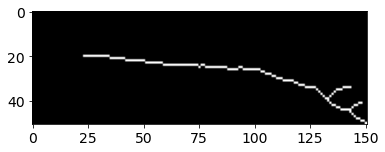

In [230]:
plt.imshow(unpruned_skell[20][0],cmap=plt.cm.gray)
#plt.imshow(centerlines[20],cmap=plt.cm.gray)

In [15]:
prune2(skel,list(poles))

In [195]:
poles = splines[n][3]
[xs,ys] = np.transpose(splines[n][0]).copy()
[yo,xo] = np.transpose(outlines[n][0]).copy()

In [258]:
outline=outlines[n][0]
tck,u=splprep(np.transpose(outline), per=1)
V=np.array(splev(u,tck,der=1)).T
A=np.array(splev(u,tck,der=2)).T
K = [abs(np.cross(V[i],A[i]))/(np.linalg.norm(V[i])**3) for i in range(0,len(u))]

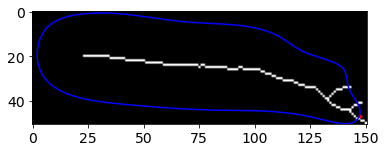

In [196]:
plt.imshow(skel,cmap=plt.cm.gray)
plt.plot(poles[0][0],poles[0][1],'r.')
#plt.plot(poles[1][0],poles[1][1],'r.')
plt.plot(xs,ys,'b-')

3310120


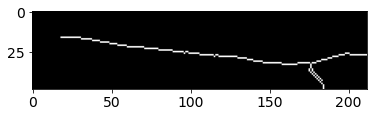

In [34]:
skel=np.array(unpruned_skell[n][0])
mask = np.array(maskl[n][0])
plt.imshow(skel,cmap=plt.cm.gray)
print(unpruned_skell[n][1])

In [ ]:
m = np.shape(skel)[1]
right_skel = np.array(skel[:,m//2:m])
right_mask = np.array(mask[:,m//2:m])
right_root = bool_sort(right_skel)[0]

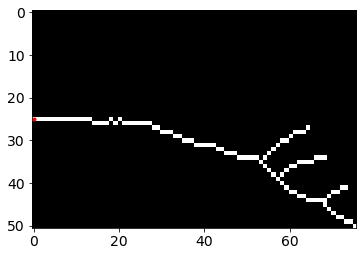

In [ ]:
plt.imshow(right_skel,cmap=plt.cm.gray)
plt.plot(right_root[1],right_root[0],'r.')

In [11]:
leaves = []
while np.any(right_skel):
    leaf = skeleton_to_centerline(right_skel)[-1]
    leaves.append(leaf)

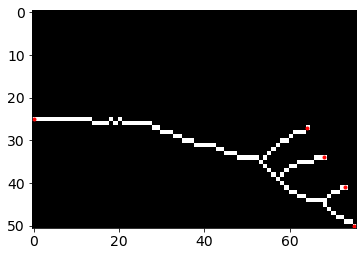

In [12]:
n = np.shape(skel)[1]
right_skel = np.array(skel[:,n//2:n])
plt.imshow(right_skel,cmap=plt.cm.gray)
plt.plot(right_root[1],right_root[0],'r.')
for leaf in leaves:
    plt.plot(leaf[1],leaf[0],'r.')

In [21]:
def fskel(mask, b_thresh=40, sk_thresh=20):
    fil=FilFinder2D(mask,mask=mask)
    fil.preprocess_image(skip_flatten=True)
    fil.create_mask(use_existing_mask=True)
    fil.medskel(verbose=False)
    unpruned_skel = fil.skeleton
    fil.analyze_skeletons(branch_thresh=b_thresh*u.pix, skel_thresh=sk_thresh*u.pix, prune_criteria='length',max_prune_iter=20)
    skel = fil.skeleton_longpath
    filaments = fil.filaments
    return unpruned_skel,skel, filaments

In [38]:
all_the_cells = os.listdir(cell_path)

# List of masks with associated timepoints and names
maskl = []
#list of skeletons (before and after branch pruning) with associated timepoints
unpruned_skell=[]
skell = []
#list of filaments before pruning with associated timepoints
filamentl = []
#overwrite skeleton_check
for cell in all_the_cells:
    time = re.findall(r'\d+', cell)
    if time != []:
        time = int(time[0])
        im_path = cell_path + cell + '/masks'
        #create skeletons; save masks, skeletons, and masks with skeletons as lists, save skeletons and skeletons with masks as images
        for mask_name in os.listdir(im_path):
            if mask_name[len(mask_name)-3:len(mask_name)]!='png':
                continue
            mask=im.imread(im_path+'/'+mask_name) #the cells mask (opencv image)
            skel_mask = cv2.copyMakeBorder(mask,20,20,20,20,cv2.BORDER_CONSTANT,None,value=0)[:,:,0]>0 #add a border to the skel
            unpruned_skel, skel,filaments = fskel(skel_mask)
            unpruned_skel = unpruned_skel[20:np.shape(unpruned_skel)[0]-20,20:np.shape(unpruned_skel)[1]-20]
            skel = skel[20:np.shape(skel)[0]-20,20:np.shape(skel)[1]-20] #remove borders from skeletons
            mask = mask[:,:,0]>0 #turn mask into a boolean array
            maskl.append([mask,time,int(mask_name[5:6])])
            unpruned_skell.append([unpruned_skel,time,int(mask_name[5:6])])
            skell.append([skel,time,int(mask_name[5:6])])
            filamentl.append([filaments,time,int(mask_name[5:6])])

#sort lists by timepoint
skell.sort(key=lambda skel: skel[1])
unpruned_skell.sort(key=lambda skel: skel[1])
maskl.sort(key=lambda skel: skel[1])
filamentl.sort(key=lambda skel: skel[1])
outl.sort(key=lambda skel: skel[1])

In [247]:
[skel[1:3]==[3302325,0] for skel in skell].index(True)

24

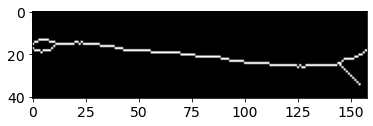

In [248]:
skel=unpruned_skell[24][0]
plt.imshow(skel,cmap=plt.cm.gray)

In [ ]:
outline_names = []
spline_names = []
times = []
idl = []
for out in outl:
    outline_names.append('algorithm_comparison'+'/'+str(out[1])+'_'+str(out[2])+'.png')
    spline_names.append('complete splines' + '/' + str(out[1]) + '_' + str(out[2]) + '.png')
    times.append(out[1])
    idl.append(out[2])

In [25]:
outdf=pd.DataFrame()
outdf['Outlines']=outline_names
outdf['Splines'] = spline_names
outdf['times'] = times
outdf['IDs'] = idl
def out_formatter(path):
    return '<img src="'+ path + '" width="512" >'

In [38]:
imagehtml = outdf.to_html(escape=False,formatters=dict(Outlines=out_formatter,Splines = out_formatter))
HTML (imagehtml)

,Outlines,Splines,times,IDs
0,,,3301940,0
1,,,3302004,0
2,,,3302013,0
3,,,3302022,0
4,,,3302032,0
5,,,3302040,0
6,,,3302137,0
7,,,3302137,1
8,,,3302146,0
9,,,3302146,1


In [12]:
help(argrelmax)

Help on function argrelmax in module scipy.signal._peak_finding:

argrelmax(data, axis=0, order=1, mode='clip')
    Calculate the relative maxima of `data`.
    
    Parameters
    ----------
    data : ndarray
        Array in which to find the relative maxima.
    axis : int, optional
        Axis over which to select from `data`. Default is 0.
    order : int, optional
        How many points on each side to use for the comparison
        to consider ``comparator(n, n+x)`` to be True.
    mode : str, optional
        How the edges of the vector are treated.
        Available options are 'wrap' (wrap around) or 'clip' (treat overflow
        as the same as the last (or first) element).
        Default 'clip'. See `numpy.take`.
    
    Returns
    -------
    extrema : tuple of ndarrays
        Indices of the maxima in arrays of integers. ``extrema[k]`` is
        the array of indices of axis `k` of `data`. Note that the
        return value is a tuple even when `data` is 1-D.
    
 

In [6]:
out = np.array(outl[n][0])
outline = skeleton_to_centerline(out,top=True)
tck,u=splprep(np.transpose(outline),per=1)
[ys,xs]=splev(u,tck)
[xo,yo]=np.transpose(outline)

/home/WereSalmon/miniconda3/envs/cellpose/lib/python3.8/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][178]=x[1][0]
  warnings.warn(RuntimeWarning('Setting x[%d][%d]=x[%d][0]' %


In [42]:
average_xo,average_yo,centroid_o=explore_poles(xo,yo,long=False)
average_xs,average_ys,centroid_s=explore_poles(xs,ys,long=False)

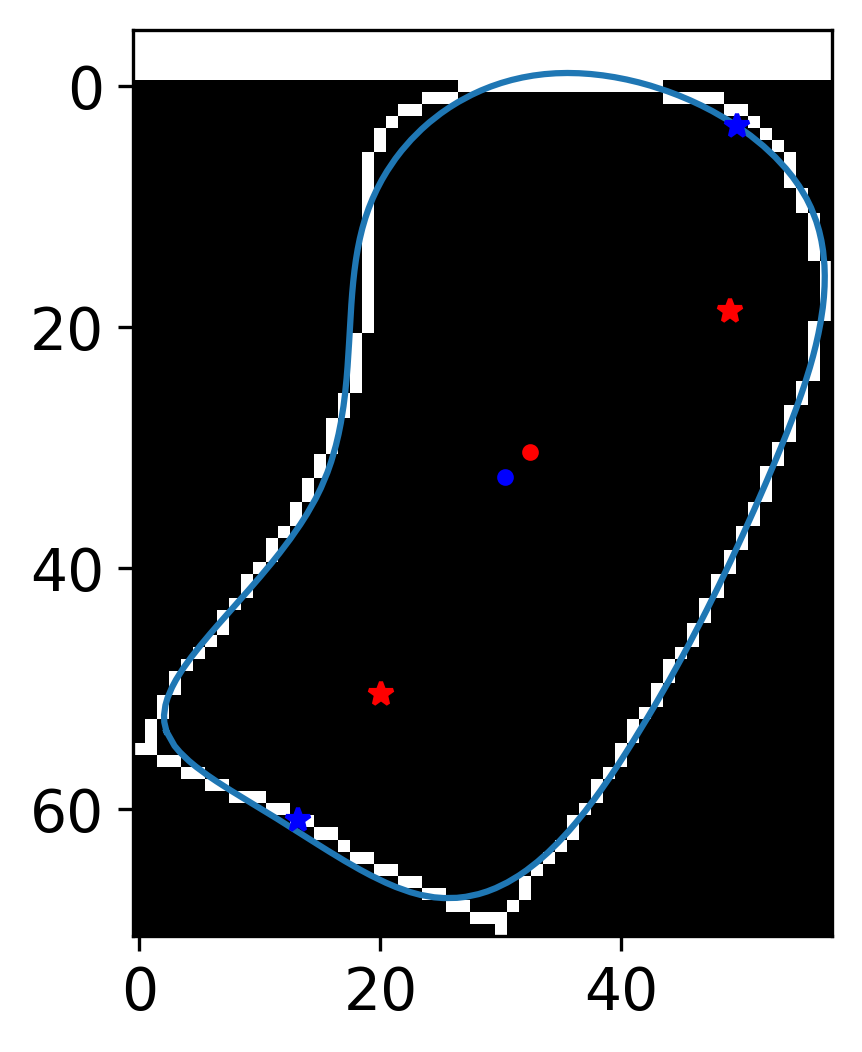

In [43]:
plt.imshow(outl[n][0],cmap=plt.cm.gray)
plt.plot(xs,ys)
plt.plot(average_xs,average_ys,'b*')
plt.plot(centroid_s[0],centroid_s[1],'b.')
plt.plot(average_xo,average_yo,'r*')
plt.plot(centroid_o[0],centroid_o[1],'r.')